# Generalization Dataset 1

### NOTE: This notebook was originally ran using python 3.11.3 and R version 

# GET EVERYTHING READY

In [43]:
%%R
# Check R version
R.version.string
print(getRversion())


[1] ‘4.3.2’


In [22]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import ticker
from scipy.optimize import curve_fit
from scipy.stats import pearsonr, spearmanr, rankdata
from subject import Subject
from util import *

# R stuff:
%load_ext rpy2.ipython

# Settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
sns.set_theme(style="whitegrid")
sns.set_context("paper", font_scale=1.8, rc={"lines.linewidth": 2.5,"lines.markersize": 8})

# FITTING FUNCTION
# --------------------------------------------------------
def exponential_decay(x, asymp_to, improvement, alpha):
    return asymp_to + improvement * np.exp(-alpha * x)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


# Read and parse data

In [23]:
vars_to_keep = ['participant', 'run', 'trial', 'trial_num_python', 'event', 'duration', 'routineClock_t', 'resp', 'corrResp', 'wasRnf', 'outcome', 'cond_val', 'phase', 'position', 'condition', 'nResp_untilRnf', 'list','devalued_coin', 'date']

subjects = Subject.get_healthy_controls()
runs = range(1,3)
blocks_per_run = range(1,11)
# Create A DF of all the subjects
all_subjects_df = {}
for sub in subjects:
    all_sub_data = pd.read_csv(get_trial_info(sub.subid)).loc[:,vars_to_keep]
    all_subjects_df[sub.subid] = {'all_data': all_sub_data, 'blocks': {}, 'runs': {}}
    for run in runs:
        # fill in runs
        all_subjects_df[sub.subid]['runs'][run] = all_sub_data[all_sub_data['run'] == run-1]
        # fill in blocks
        for block in blocks_per_run:
            all_subjects_df[sub.subid]['blocks'][(run-1)*10+block] = get_block(sub.subid, run, block).loc[:,vars_to_keep]


# Create every action data:
# --------------------------------------------------------
# Create a list to collect each subject's processed data
all_subjects_data = []
Dependent_vars = pd.DataFrame()

for subID in all_subjects_df.keys():
    data_subset = all_subjects_df[subID]['all_data']
    duration_data = data_subset[data_subset.event == 'training_period_start'].copy().reset_index(drop=True)
    data_subset = data_subset[data_subset['event'] == 'training_resp'].copy().reset_index(drop=True)
    # Map trial number to duration for each trial
    trial_to_duration = duration_data.set_index('trial')['duration'].to_dict()
    data_subset['duration'] = data_subset['trial'].map(trial_to_duration)
    # add isCorrectResp:
    data_subset['isCorrectResp'] = data_subset['resp'] == data_subset['corrResp']
    # Add IPI and IPI_abs_diff just for correct responses
    correct_resp_subset = data_subset[data_subset['isCorrectResp'] == True].copy()
    correct_resp_subset.loc[:, 'IPI'] = correct_resp_subset.groupby('trial')['routineClock_t'].diff()
    correct_resp_subset.loc[:, 'IPI_abs_diff'] = correct_resp_subset.groupby('trial')['IPI'].diff().abs()
    # Calculate IPI and IPI_abs_diff only for correct responses
    data_subset.loc[correct_resp_subset.index, 'IPI'] = correct_resp_subset['IPI']
    data_subset.loc[correct_resp_subset.index, 'IPI_abs_diff'] = correct_resp_subset['IPI_abs_diff']

    all_subjects_data.append(data_subset)
    Dependent_vars = pd.concat([Dependent_vars, pd.DataFrame({'subID': [subID], 'devaluation_ratio': [get_devaluation_ratio(subID)]})])

Dependent_vars = Dependent_vars.reset_index(drop=True)

# Concatenate all subjects' data into one DataFrame
main_data_df = pd.concat(all_subjects_data, ignore_index=True)
main_data_df.rename(columns={'participant': 'subID'}, inplace=True)

main_data_df['subID'] = main_data_df['subID'].astype(int)
main_data_df['run'] = main_data_df['run'].astype(int)
main_data_df['trial'] = main_data_df['trial'].astype(int)
main_data_df['run'] = main_data_df['run'] + 1  # Adjust run numbers to start from 1
main_data_df['trial'] = main_data_df['trial'] + 1  # Adjust trial numbers to start from 1

# Create trial-level data (trials are kind of blocks here):
# ---------------------------------------------------------
agg_dict = {
    'IPI': ['mean'],
    'IPI_abs_diff': 'mean',
    'event': 'count',
    'isCorrectResp': 'mean',
    'routineClock_t': 'first',
}

# create a column of one raw per sub per trial:
trial_level_df = main_data_df.groupby(['subID', 'trial', 'run', 'duration', 'corrResp', 'outcome', ]).agg(agg_dict).reset_index()
flattened_columns = []
for col in trial_level_df.columns:
    if isinstance(col, tuple):
        var_name, agg_name = col
        # Check if the variable had multiple aggregations
        if isinstance(agg_dict.get(var_name), list) and len(agg_dict[var_name]) > 1:
            flattened_columns.append(f"{var_name}_{agg_name}")
        else:
            flattened_columns.append(var_name)
    else:
        flattened_columns.append(col)
trial_level_df.columns = flattened_columns

trial_level_df.rename(columns={'event': 'n_resp', 'routineClock_t': 'first_RT'}, inplace=True)
trial_level_df['resp_rate'] = trial_level_df['n_resp'] / trial_level_df['duration']

# Convert IPI_abs_diff and first_RT to milliseconds:
for var in ['IPI_abs_diff', 'first_RT']:
    trial_level_df[var] = trial_level_df[var] * 1000

# ----- IPI Consistency (Automaticity) -----

## Analysis - modeling

In [24]:
IPI_consistency_data_by_trial = main_data_df.copy()
IPI_consistency_data_by_trial.rename(columns={'outcome': 'stim_condition', 'subID': 'sub'}, inplace=True)
# add group column
IPI_consistency_data_by_trial['group'] = 'HC'
# convert to milliseconds:
IPI_consistency_data_by_trial['IPI_abs_diff'] = IPI_consistency_data_by_trial['IPI_abs_diff'] * 1000


### Modeling + Fig 4A

mean R^2: 0.153


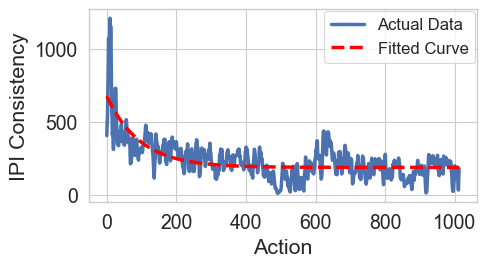

In [25]:
var = 'IPI_abs_diff'
var_of_comparison = 'stim_condition' 
to_smooth = True
smoothing_window = 5
min_period = None

sns.set_context("paper", font_scale=1.6, rc={
    "lines.linewidth": 2.5,
    "lines.markersize": 8
})

# fit the exponential decay to the data:
# -------------------------------------------
# prepare the data:
relevant_trial_data = IPI_consistency_data_by_trial.copy()
if var_of_comparison:
    grouping_factos = ['sub', 'stim_condition']
    stim_condition = var_of_comparison
else:
    grouping_factos = ['sub']
    stim_condition = 'all_stimuli'

relevant_trial_data.loc[:, 'stim_abs_trial'] = relevant_trial_data.groupby(grouping_factos).cumcount()

# remove nans:
relevant_trial_data = relevant_trial_data[relevant_trial_data[var].notna()]

results_df = pd.DataFrame()

# run the fitting procedure:
for sub in relevant_trial_data['sub'].unique():
    # prepare sub data:
    # ------------------------
    data = relevant_trial_data[relevant_trial_data['sub'] == sub]
    data = data.copy()
    data.loc[:, 'smoothed_data'] = data.groupby('stim_condition')[var].transform(lambda x: x.rolling(window=smoothing_window, min_periods=min_period).mean())
    # remove nans:
    data = data[data['smoothed_data'].notna()].reset_index(drop=True)
    # re-create the stim_abs_trial:
    data.loc[:, 'stim_abs_trial'] = data.groupby(grouping_factos).cumcount()
    
    # Average across conditions at each trial
    avg_data = data.groupby('stim_abs_trial')['smoothed_data'].mean().reset_index()

    x_data = avg_data['stim_abs_trial']
    y_data_smoothed = avg_data['smoothed_data']

    # fit the exponential decay:
    # --------------------------
    # Calculate initial guesses from the data:
    y_start = y_data_smoothed.iloc[0]
    y_end = y_data_smoothed.iloc[-1]
    improvement_guess = abs(y_start - y_end)
    asymp_guess = y_end
    p0 = (asymp_guess, improvement_guess, 0.01)

    popt, pcov = curve_fit(exponential_decay, x_data, y_data_smoothed, p0=p0, maxfev=100000, bounds=([0, 0, 0], [35000, 35000, 10000]))
    y_predicted = exponential_decay(x_data, *popt)

    # Calculate the residuals, sum of squares of residuals and the total sum of squares
    residuals = y_data_smoothed - y_predicted
    ss_residuals = np.sum(residuals**2)
    ss_total = np.sum((y_data_smoothed - np.mean(y_data_smoothed))**2)
    # calculate the R squared:
    r_squared = 1 - (ss_residuals / ss_total)

    # relative gain of performance ('improvement') by the final point (according to the model):
    end_of_training_pred = exponential_decay(x_data.max(), *popt)
    relative_improvement_accomplished = 1 - ((end_of_training_pred - popt[0]) / popt[1])

    results_df = pd.concat([results_df, pd.DataFrame({'sub': sub, 'group': data['group'].iloc[0], 'stim_condition': stim_condition, 'asymp_to': popt[0], 'improvement': popt[1], 'alpha': popt[2], 'end_of_training_pred': end_of_training_pred, 'relative_improvement_accomplished': relative_improvement_accomplished, 'r_squared': r_squared}, index=[0])])
    
    # plot example participant data and fitted curve:
    if sub == 72:
        df = pd.DataFrame({'x_data': x_data, 'y_data_smoothed': y_data_smoothed, 'stim_condition': data['stim_condition']})
        fig, axes = plt.subplots(1, 1, figsize=(5, 2.5))
        sns.lineplot(x=x_data, y=y_data_smoothed, markers=True, ax=axes, errorbar=('se', 1), data=df, label='Actual Data')
        sns.lineplot(x=x_data, y=y_predicted, ax=axes, color='red', linestyle='--', label='Fitted Curve')
        axes.set_xlabel('Action')
        axes.set_ylabel('IPI Consistency')
        axes.legend(
            loc='upper right',
            fontsize=12,
            bbox_to_anchor=(1, 1),
            borderaxespad=0.1      
        )

results_df = results_df.reset_index(drop=True)
print(f'mean R^2: {results_df.r_squared.mean().round(3)}')

In [26]:
# add the data to the main data:
# -------------------------------------------
Dependent_vars_copy = Dependent_vars.copy()
Dependent_vars_copy.rename(columns={'subID': 'sub'}, inplace=True)
main_data_df_w_fitting = pd.merge(Dependent_vars_copy, results_df.drop(columns=['stim_condition']), on=['sub'], how='left')

### Fig 4B + stats

Pearson correlation for end_of_training_pred with habit_level: 0.211, p-value: 0.00559
Degrees of freedom for Pearson correlation: 142
Spearman correlation for end_of_training_pred with habit_level: 0.140, p-value: 0.04745
(144, 10)


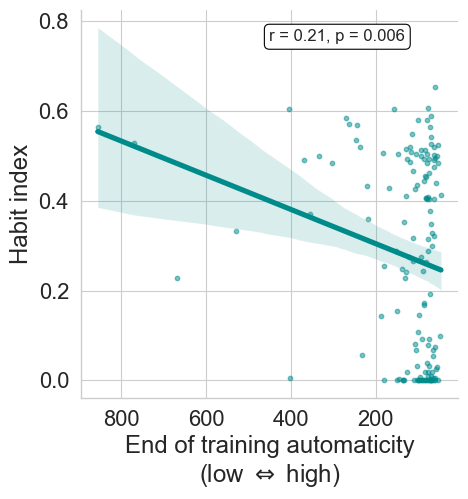

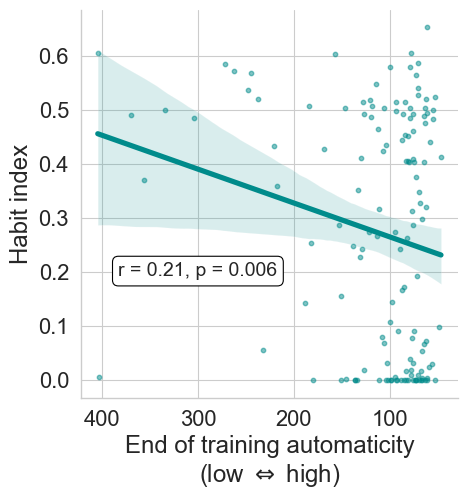

Removed 4 data points for visualization purposes


In [27]:
only_after_devalued_data = main_data_df_w_fitting.copy()
only_after_devalued_data['habit_level'] = 1 - only_after_devalued_data['devaluation_ratio']

# Pearson correlation (and Spearman to verify robustness using non-parametric correlation):
pearson_corr, pearson_p = pearsonr(only_after_devalued_data['end_of_training_pred'], only_after_devalued_data['habit_level'], alternative='greater')
print(f"Pearson correlation for end_of_training_pred with habit_level: {pearson_corr:.3f}, p-value: {pearson_p:.5f}")
print(f"Degrees of freedom for Pearson correlation: {len(only_after_devalued_data['end_of_training_pred']) - 2}")
spearman_corr, spearman_p = spearmanr(only_after_devalued_data['end_of_training_pred'], only_after_devalued_data['habit_level'], alternative='greater')
print(f"Spearman correlation for end_of_training_pred with habit_level: {spearman_corr:.3f}, p-value: {spearman_p:.5f}")

sns.set_context("paper", font_scale=1.8, rc={
    "lines.linewidth": 2.5,
    "lines.markersize": 8
})

pallette = ['#008B8B']

print(only_after_devalued_data.shape)
sns.lmplot(data=only_after_devalued_data, x='end_of_training_pred', y='habit_level', hue='group', palette=pallette, order=1,scatter_kws={'s': 10, 'alpha': 0.5}, height=5, aspect=1, legend=False) 
plt.ylabel('Habit index')
plt.xlabel('End of training automaticity\n(low $\Leftrightarrow$ high)')
# add r and p value:
plt.annotate(f"r = {pearson_corr:.2f}, p = {pearson_p:.3f}", xy=(0.5, 0.95), xycoords="axes fraction", fontsize=12, ha="left", va="top", bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black"))
plt.gca().invert_xaxis()  
plt.show()

# NOTE: now without outliers for visualization purposes:
# ---------------------------------------------------------
sns.lmplot(data=only_after_devalued_data[only_after_devalued_data.end_of_training_pred<500], x='end_of_training_pred', y='habit_level', hue='group', palette=pallette, order=1,scatter_kws={'s': 10, 'alpha': 0.5}, height=5, aspect=1, legend=False) 
plt.ylabel('Habit index')
plt.xlabel('End of training automaticity\n(low $\Leftrightarrow$ high)')
plt.annotate(f"r = {pearson_corr:.2f}, p = {pearson_p:.3f}", xy=(0.1, 0.35), xycoords="axes fraction", fontsize=14, ha="left", va="top", bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black"))
plt.gca().invert_xaxis()  

plt.show()
# print how many DP are excluded:
print(f"Removed {only_after_devalued_data.shape[0] - only_after_devalued_data[only_after_devalued_data.end_of_training_pred<500].shape[0]} data points for visualization purposes")



### Fig. S4 (rank plot)

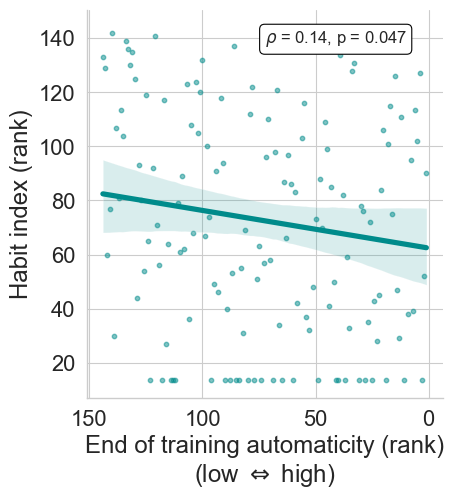

In [28]:
df = only_after_devalued_data.copy()
df['x_rank'] = rankdata(df['end_of_training_pred'])
df['y_rank'] = rankdata(df['habit_level'])

sns.set_context("paper", font_scale=1.8, rc={"lines.linewidth": 2.5, "lines.markersize": 8})

g = sns.lmplot(
    data=df, x='x_rank', y='y_rank',
    hue='group', palette=pallette, order=1,
    scatter_kws={'s': 10, 'alpha': 0.5},
    height=5, aspect=1, legend=False
)

plt.ylabel('Habit index (rank)')
plt.xlabel('End of training automaticity (rank)\n(low $\Leftrightarrow$ high)')

plt.annotate(
    f"$\\rho$ = {spearman_corr:.2f}, p = {spearman_p:.3f}",
    xy=(0.5, 0.95), xycoords="axes fraction",
    fontsize=12, ha="left", va="top",
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black")
)

plt.gca().invert_xaxis()
plt.show()


## --- TERTILES of habit expression

In [29]:
# checking the proportion of participants with perfect goal-directed behavior (0 habits)
only_after_devalued_data['habit_level'].shape
only_after_devalued_data[only_after_devalued_data['habit_level'] == 0].shape
26/144

0.18055555555555555

### End of training automaticity across the tertiles

#### Fig 4C

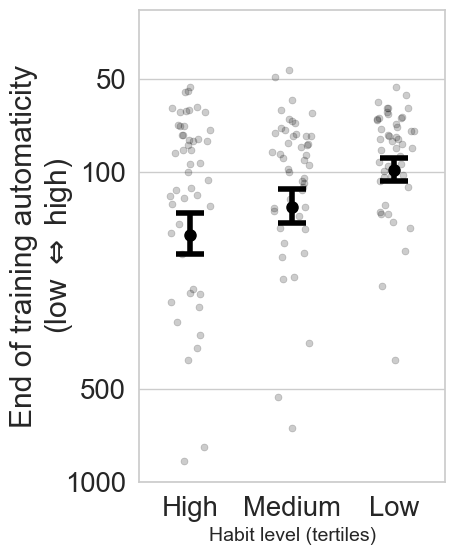

In [30]:
sns.set(font_scale=1.8)
sns.set_style("whitegrid")

# add tertile:
only_after_devalued_data['tertile'] = pd.qcut(only_after_devalued_data['devaluation_ratio'], 3, labels=["T1", "T2", "T3"])
only_after_devalued_data['tertile'] = (only_after_devalued_data['tertile'].cat.rename_categories({"T1": "High", "T2": "Medium", "T3": "Low"}))

fig, ax = plt.subplots(figsize=(5, 6))

habit_order = ["High", "Medium", "Low"]

# compute means/SE
grouped = only_after_devalued_data.groupby("tertile", observed=True)["end_of_training_pred"]
means = grouped.mean().reindex(habit_order)
ses = grouped.sem().reindex(habit_order)

# numeric positions for categories
x_pos = np.arange(len(habit_order))

ax.errorbar(
    x=x_pos,
    y=means,
    yerr=ses,
    fmt='o',
    color='black',
    capsize=10,
    capthick=4,
    markersize=8,
    linewidth=4,
    zorder=3
)

ax.set_xticks(x_pos)
ax.set_xticklabels(habit_order)

# Plot individual points
sns.stripplot(
    data=only_after_devalued_data,
    x="tertile",
    y="end_of_training_pred",
    color="black",
    order=habit_order,
    jitter=0.2,
    alpha=0.2,
    edgecolor='black',
    linewidth=0.5,
    ax=ax
)

# log scale:
plt.yscale('log')
ax.set_yticks([50, 100, 500, 1000])
ax.get_yaxis().set_major_formatter(ticker.ScalarFormatter())

ax.set_ylabel('End of training automaticity\n(low $\\Leftrightarrow$ high)',labelpad=-7)
ax.set_xlabel("Habit level (tertiles)", fontsize=14)
ax.invert_yaxis()
plt.ylim(top=30)

plt.tight_layout()
plt.show()


#### stats

In [31]:
%%R -i only_after_devalued_data
library(car)
library(lmtest)    
library(sandwich)
library(emmeans)

# Ensure factor coding
only_after_devalued_data$tertile <- factor(only_after_devalued_data$tertile,levels = c("Low", "Medium", "High"))
# effect coding:
contrasts(only_after_devalued_data$tertile) <- contr.sum(3)

model <- lm(end_of_training_pred ~ tertile, data = only_after_devalued_data)
print(summary(model))
print(ncvTest(model))   # Non-constant variance score test
print(Anova(model, type = "III", white.adjust = TRUE))

print('>>>>> Corrected SEs for between level comparison <<<<<')
Vsum <- vcovHC(model, type = "HC3")
emm_t <- emmeans(model, ~ tertile, vcov. = Vsum)
print(pairs(emm_t, adjust = "none"))
print('>>>>>>>>>>>><<<<<<<<<<<')


Call:
lm(formula = end_of_training_pred ~ tertile, data = only_after_devalued_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-106.23  -55.45  -30.57    3.81  695.10 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 129.3587     9.9851  12.955   <2e-16 ***
tertile1    -30.9272    14.1211  -2.190   0.0302 *  
tertile2      0.7367    14.1211   0.052   0.9585    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 119.8 on 141 degrees of freedom
Multiple R-squared:  0.04242,	Adjusted R-squared:  0.02884 
F-statistic: 3.123 on 2 and 141 DF,  p-value: 0.04706

Non-constant Variance Score Test 
Variance formula: ~ fitted.values 
Chisquare = 32.49999, Df = 1, p = 1.1919e-08
Analysis of Deviance Table (Type III tests)

Response: end_of_training_pred
             Df       F  Pr(>F)    
(Intercept)   1 164.340 < 2e-16 ***
tertile       2   3.854 0.02346 *  
Residuals   141                    
---
Signif. codes:  

Coefficient covariances computed by hccm()


### Trajectories of the tertiles

#### Fig 4D

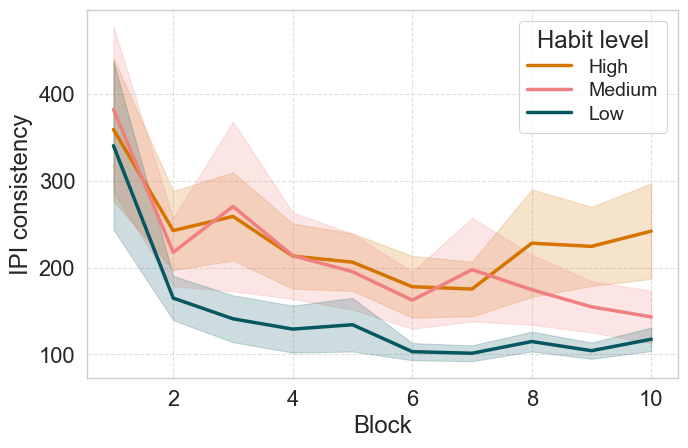

In [32]:
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.8, rc={
    "lines.linewidth": 2.5,
    "lines.markersize": 8
})
palette = ["darkgreen", "lightgray"]
palette=["#D57500", "lightcoral", "#065760"]
palette_mapping = {
    'Low': palette[2],
    'Medium': palette[1],
    'High': palette[0]
}

fig_size_factor = 0.8
fig_size = (9*fig_size_factor, 6*fig_size_factor)

# --- Data prep ---
IPI_consistency_data_by_trial_isHabitual = IPI_consistency_data_by_trial.merge(
    only_after_devalued_data[['sub', 'tertile']],
    on='sub',
    how='left'
)

IPI_consistency_data_by_trial_isHabitual_byBlock = IPI_consistency_data_by_trial_isHabitual.groupby(['sub', 'trial', 'tertile', 'stim_condition'], observed=True).agg({'IPI_abs_diff': 'mean'}).reset_index()
IPI_consistency_data_by_trial_isHabitual_byBlock['stim_abs_trial'] = IPI_consistency_data_by_trial_isHabitual_byBlock.groupby(['sub', 'stim_condition'], observed=True).cumcount() + 1

measure_mean = IPI_consistency_data_by_trial_isHabitual_byBlock.IPI_abs_diff.mean()
measure_std = IPI_consistency_data_by_trial_isHabitual_byBlock.IPI_abs_diff.std()
# remove outlies with more than 10 SD from the mean (for visualization purposes):
IPI_consistency_data_by_trial_isHabitual_byBlock = IPI_consistency_data_by_trial_isHabitual_byBlock[
    (IPI_consistency_data_by_trial_isHabitual_byBlock['IPI_abs_diff'] < measure_mean + 10 * measure_std) &
    (IPI_consistency_data_by_trial_isHabitual_byBlock['IPI_abs_diff'] > measure_mean - 10 * measure_std)
].reset_index(drop=True)

custom_labels = {
    'Low': 'Low',
    'Medium': 'Medium',
    'High': 'High'
}

IPI_consistency_data_by_trial_isHabitual_byBlock = IPI_consistency_data_by_trial_isHabitual_byBlock.groupby(['sub', 'tertile', 'stim_abs_trial'], observed=True).agg({'IPI_abs_diff': 'mean'}).reset_index()

fig, axe = plt.subplots(1, 1, figsize=fig_size)
sns.lineplot(
    data=IPI_consistency_data_by_trial_isHabitual_byBlock,
    x='stim_abs_trial',
    y='IPI_abs_diff',
    hue='tertile',
    palette=palette_mapping,
    legend='full',
    errorbar=('se', 1),
    ax=axe
)
axe.set_xlabel('Block')
axe.set_ylabel('IPI consistency')

# Clean legend
handles, labels = axe.get_legend_handles_labels()
unique = []
used = set()
for h, l in zip(handles, labels):
    if l not in used and l in custom_labels:
        unique.append((h, custom_labels[l]))
        used.add(l)
if unique:
    handles_clean, labels_clean = zip(*unique)
    legend = axe.legend(handles_clean, labels_clean, loc='upper right', title='Habit level', labelspacing=0.2)
    for text in legend.texts:
        text.set_fontsize(14)

axe.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


#### stats

In [33]:
# get mean IPI_abs_diff per sub:
IPI_consistency_per_block = IPI_consistency_data_by_trial_isHabitual.groupby(['sub', 'trial', 'tertile'], observed=True)['IPI_abs_diff'].mean().reset_index()
IPI_consistency_per_block
IPI_consistency_per_block['tertile'].value_counts()

# Aggregate by block
IPI_consistency_per_block = IPI_consistency_data_by_trial_isHabitual.groupby(['sub', 'trial', 'tertile', 'stim_condition'], observed=True).agg({'IPI_abs_diff': 'mean'}).reset_index()
IPI_consistency_per_block['stim_abs_trial'] = IPI_consistency_per_block.groupby(['sub', 'stim_condition'], observed=True).cumcount() + 1
IPI_consistency_per_block = IPI_consistency_per_block.groupby(['sub', 'tertile', 'stim_abs_trial'], observed=True).agg({'IPI_abs_diff': 'mean'}).reset_index()

[1] "============================== MODEL SUMMARY [effect coding] =============================="
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: IPI_abs_diff ~ stim_abs_trial * tertile + (1 | sub)
   Data: IPI_consistency_per_block

REML criterion at convergence: 22363.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.1358 -0.1397 -0.0582  0.0420 27.1301 

Random effects:
 Groups   Name        Variance Std.Dev.
 sub      (Intercept) 100409   316.9   
 Residual             301606   549.2   
Number of obs: 1437, groups:  sub, 144

Fixed effects:
                        Estimate Std. Error      df t value Pr(>|t|)    
(Intercept)               220.50      30.12  137.81   7.321 1.86e-11 ***
stim_abs_trial            -67.39      14.49 1286.94  -4.650 3.67e-06 ***
tertile1                  -75.39      42.59  137.74  -1.770  0.07890 .  
tertile2                   62.17      42.60  137.88   1.459  0.14676    
stim_abs_trial:tertil

NOTE: Results may be misleading due to involvement in interactions


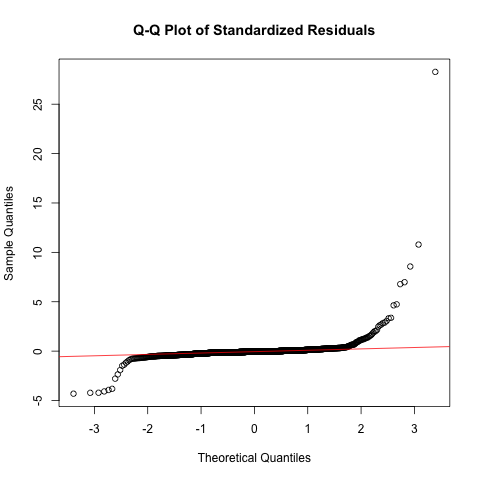

In [34]:
%%R -i IPI_consistency_per_block
library(car)
library(lme4)
library(lmerTest)
library(robustlmm)
library(clubSandwich)
library(emmeans)
library(lmtest)

# Prepare data
IPI_consistency_per_block$tertile <- factor(IPI_consistency_per_block$tertile, levels = c("Low","Medium","High"))
IPI_consistency_per_block <- IPI_consistency_per_block[!is.na(IPI_consistency_per_block$IPI_abs_diff), ]
IPI_consistency_per_block$stim_abs_trial <- scale(IPI_consistency_per_block$stim_abs_trial)

print("============================== MODEL SUMMARY [effect coding] ==============================")
# Set effect coding
contrasts(IPI_consistency_per_block$tertile) <- contr.sum(3)
model_reg <- lmer(IPI_abs_diff ~ stim_abs_trial*tertile + (1|sub), data = IPI_consistency_per_block)
print(summary(model_reg))

# Heteroskedasticity checks
print("============================== HETEROSKEDASTICITY TESTS ==============================")
resid_data <- data.frame(sq_resid = residuals(model_reg)^2, fitted = fitted(model_reg))
bp_model <- lm(sq_resid ~ fitted, data = resid_data)
print("Breusch-Pagan test:")
print(summary(bp_model))

print("============================== Outliers TEST ==============================")
# Extract standardized residuals
std_resid <- residuals(model_reg) / sd(residuals(model_reg))

# Count extreme outliers (beyond ±3 SD)
n_outliers <- sum(abs(std_resid) > 3)
pct_outliers <- 100 * n_outliers / length(std_resid)

print(paste("Extreme outliers (>3 SD):", n_outliers, 
            "(", round(pct_outliers, 1), "%)"))

# Quick Q-Q plot
qqnorm(std_resid, main = "Q-Q Plot of Standardized Residuals")
qqline(std_resid, col = "red")

# Robustlmm analysis
print("============================== ROBUST MODEL (rlmer): Model summary ==============================")
model_robust <- rlmer(IPI_abs_diff ~ stim_abs_trial*tertile + (1|sub), data = IPI_consistency_per_block)
print(summary(model_robust))

print("============================== Coefficient names: ==============================")
print(names(fixef(model_robust)))

print("============================== Main effect of tertile: ==============================")
print(joint_tests(emmeans(model_robust, ~ tertile)))

print("============================== Main effect of stim_abs_trial: ==============================")
print(test(emtrends(model_robust, ~ 1, var = "stim_abs_trial")))

print("============================== Tertile x Trial interaction: ==============================")
print(joint_tests(emtrends(model_robust, ~ tertile, var = "stim_abs_trial")))


# ----- Response rate -----

## Modeling

In [35]:
IPI_consistency_data_by_trial = trial_level_df.copy()
IPI_consistency_data_by_trial.rename(columns={'outcome': 'stim_condition', 'subID': 'sub'}, inplace=True)
IPI_consistency_data_by_trial['group'] = 'HC' # add group 'HC'


In [36]:
var = 'resp_rate'
var_of_comparison = 'stim_condition' 
to_smooth = True
smoothing_window = 1
min_period = None

sns.set_context("paper", font_scale=1.6, rc={
    "lines.linewidth": 2.5,
    "lines.markersize": 8
})

# fit the exponential decay to the data:
# -------------------------------------------
# prepare the data:
relevant_trial_data = IPI_consistency_data_by_trial.copy()
if var_of_comparison:
    grouping_factos = ['sub', 'stim_condition']
    stim_condition = var_of_comparison
else:
    grouping_factos = ['sub']
    stim_condition = 'all_stimuli'

relevant_trial_data.loc[:, 'stim_abs_trial'] = relevant_trial_data.groupby(grouping_factos).cumcount()

# remove nans:
relevant_trial_data = relevant_trial_data[relevant_trial_data[var].notna()]

results_df = pd.DataFrame()

# run the fitting procedure:
for sub in relevant_trial_data['sub'].unique():
    # prepare sub data:
    # ------------------------
    data = relevant_trial_data[relevant_trial_data['sub'] == sub]
    data = data.copy()
    data.loc[:, 'smoothed_data'] = data.groupby('stim_condition')[var].transform(lambda x: x.rolling(window=smoothing_window, min_periods=min_period).mean())
    # remove nans:
    data = data[data['smoothed_data'].notna()].reset_index(drop=True)
    # re-create the stim_abs_trial:
    data.loc[:, 'stim_abs_trial'] = data.groupby(grouping_factos).cumcount()
    
    # Average across conditions at each trial
    avg_data = data.groupby('stim_abs_trial')['smoothed_data'].mean().reset_index()

    x_data = avg_data['stim_abs_trial']
    y_data_smoothed = avg_data['smoothed_data']

    # fit the exponential decay:
    # --------------------------
    # Calculate initial guesses from the data:
    y_start = y_data_smoothed.iloc[0]
    y_end = y_data_smoothed.iloc[-1]
    improvement_guess = abs(y_start - y_end)
    asymp_guess = y_end
    p0 = (asymp_guess, improvement_guess, 0.01)

    popt, pcov = curve_fit(exponential_decay, x_data, y_data_smoothed, p0=p0, maxfev=100000, bounds=([0, -3500, -1000], [3500, 3500, 1000]))
    y_predicted = exponential_decay(x_data, *popt)

    # Calculate the residuals, sum of squares of residuals and the total sum of squares
    residuals = y_data_smoothed - y_predicted
    ss_residuals = np.sum(residuals**2)
    ss_total = np.sum((y_data_smoothed - np.mean(y_data_smoothed))**2)
    # calculate the R squared:
    r_squared = 1 - (ss_residuals / ss_total)

    # relative gain of performance ('improvement') by the final point (according to the model):
    end_of_training_pred = exponential_decay(x_data.max(), *popt)
    relative_improvement_accomplished = 1 - ((end_of_training_pred - popt[0]) / popt[1])

    results_df = pd.concat([results_df, pd.DataFrame({'sub': sub, 'group': data['group'].iloc[0], 'stim_condition': stim_condition, 'asymp_to': popt[0], 'improvement': popt[1], 'alpha': popt[2], 'end_of_training_pred': end_of_training_pred, 'relative_improvement_accomplished': relative_improvement_accomplished, 'r_squared': r_squared}, index=[0])])
    
results_df = results_df.reset_index(drop=True)
print(f'mean R^2: {results_df.r_squared.mean().round(3)}')

mean R^2: 0.571


In [37]:
# add the data to the main data:
# -------------------------------------------
Dependent_vars_copy = Dependent_vars.copy()
Dependent_vars_copy.rename(columns={'subID': 'sub'}, inplace=True)
main_data_df_w_fitting = pd.merge(Dependent_vars_copy, results_df.drop(columns=['stim_condition']), on=['sub'], how='left')

## stats (and plot)

(144, 10)


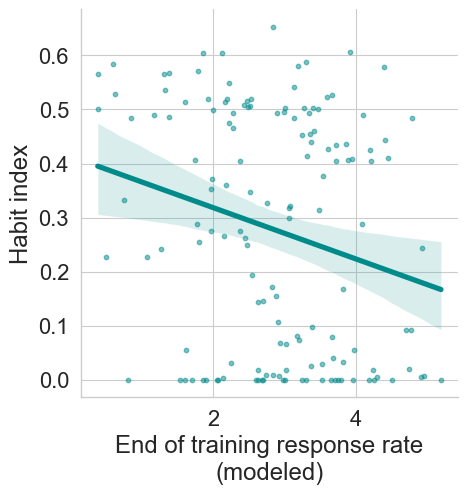

Pearson correlation for end_of_training_pred with habit_level: -0.231, p-value: 0.0026
Spearman correlation for end_of_training_pred with habit_level: -0.205, p-value: 0.0070


In [38]:
sns.set_context("paper", font_scale=1.8, rc={
    "lines.linewidth": 2.5,
    "lines.markersize": 8
})

only_after_devalued_data = main_data_df_w_fitting.copy()
only_after_devalued_data['habit_level'] = 1 - only_after_devalued_data['devaluation_ratio']

pallette = ['#008B8B']

print(only_after_devalued_data.shape)
sns.lmplot(data=only_after_devalued_data, x='end_of_training_pred', y='habit_level', hue='group', palette=pallette, order=1,scatter_kws={'s': 10, 'alpha': 0.5}, height=5, aspect=1, legend=False) 
plt.ylabel('Habit index')
plt.xlabel('End of training response rate\n(modeled)')
plt.show()

# Pearson correlation (and Spearman to verify robustness using non-parametric correlation):
pearson_corr, pearson_p = pearsonr(only_after_devalued_data['end_of_training_pred'], only_after_devalued_data['habit_level'], alternative='less')
print(f"Pearson correlation for end_of_training_pred with habit_level: {pearson_corr:.3f}, p-value: {pearson_p:.4f}")
spearman_corr, spearman_p = spearmanr(only_after_devalued_data['end_of_training_pred'], only_after_devalued_data['habit_level'], alternative='less')
print(f"Spearman correlation for end_of_training_pred with habit_level: {spearman_corr:.3f}, p-value: {spearman_p:.4f}")

# ----- First RT -----

## Modeling

In [39]:
IPI_consistency_data_by_trial = trial_level_df.copy()
IPI_consistency_data_by_trial.rename(columns={'outcome': 'stim_condition', 'subID': 'sub'}, inplace=True)
IPI_consistency_data_by_trial['group'] = 'HC' # add group 'HC'


In [40]:
var = 'first_RT'
var_of_comparison = 'stim_condition' 
to_smooth = True
smoothing_window = 1
min_period = None

sns.set_context("paper", font_scale=1.6, rc={
    "lines.linewidth": 2.5,
    "lines.markersize": 8
})

# fit the exponential decay to the data:
# -------------------------------------------
# prepare the data:
relevant_trial_data = IPI_consistency_data_by_trial.copy()
if var_of_comparison:
    grouping_factos = ['sub', 'stim_condition']
    stim_condition = var_of_comparison
else:
    grouping_factos = ['sub']
    stim_condition = 'all_stimuli'

relevant_trial_data.loc[:, 'stim_abs_trial'] = relevant_trial_data.groupby(grouping_factos).cumcount()

# remove nans:
relevant_trial_data = relevant_trial_data[relevant_trial_data[var].notna()]

results_df = pd.DataFrame()

# run the fitting procedure:
for sub in relevant_trial_data['sub'].unique():
    # prepare sub data:
    # ------------------------
    data = relevant_trial_data[relevant_trial_data['sub'] == sub]
    data = data.copy()
    data.loc[:, 'smoothed_data'] = data.groupby('stim_condition')[var].transform(lambda x: x.rolling(window=smoothing_window, min_periods=min_period).mean())
    # remove nans:
    data = data[data['smoothed_data'].notna()].reset_index(drop=True)
    # re-create the stim_abs_trial:
    data.loc[:, 'stim_abs_trial'] = data.groupby(grouping_factos).cumcount()
    
    # Average across conditions at each trial
    avg_data = data.groupby('stim_abs_trial')['smoothed_data'].mean().reset_index()

    x_data = avg_data['stim_abs_trial']
    y_data_smoothed = avg_data['smoothed_data']

    # fit the exponential decay:
    # --------------------------
    # Calculate initial guesses from the data:
    y_start = y_data_smoothed.iloc[0]
    y_end = y_data_smoothed.iloc[-1]
    improvement_guess = abs(y_start - y_end)
    asymp_guess = y_end
    p0 = (asymp_guess, improvement_guess, 0.01)

    popt, pcov = curve_fit(exponential_decay, x_data, y_data_smoothed, p0=p0, maxfev=100000, bounds=([0, 0, 0], [35000, 35000, 10000]))
    y_predicted = exponential_decay(x_data, *popt)

    # Calculate the residuals, sum of squares of residuals and the total sum of squares
    residuals = y_data_smoothed - y_predicted
    ss_residuals = np.sum(residuals**2)
    ss_total = np.sum((y_data_smoothed - np.mean(y_data_smoothed))**2)
    # calculate the R squared:
    r_squared = 1 - (ss_residuals / ss_total)

    # relative gain of performance ('improvement') by the final point (according to the model):
    end_of_training_pred = exponential_decay(x_data.max(), *popt)
    relative_improvement_accomplished = 1 - ((end_of_training_pred - popt[0]) / popt[1])

    results_df = pd.concat([results_df, pd.DataFrame({'sub': sub, 'group': data['group'].iloc[0], 'stim_condition': stim_condition, 'asymp_to': popt[0], 'improvement': popt[1], 'alpha': popt[2], 'end_of_training_pred': end_of_training_pred, 'relative_improvement_accomplished': relative_improvement_accomplished, 'r_squared': r_squared}, index=[0])])
    
results_df = results_df.reset_index(drop=True)
print(f'mean R^2: {results_df.r_squared.mean().round(3)}')

mean R^2: 0.443


In [41]:
# add the data to the main data:
# -------------------------------------------
Dependent_vars_copy = Dependent_vars.copy()
Dependent_vars_copy.rename(columns={'subID': 'sub'}, inplace=True)
main_data_df_w_fitting = pd.merge(Dependent_vars_copy, results_df.drop(columns=['stim_condition']), on=['sub'], how='left')

## stats (and plot)

(144, 10)


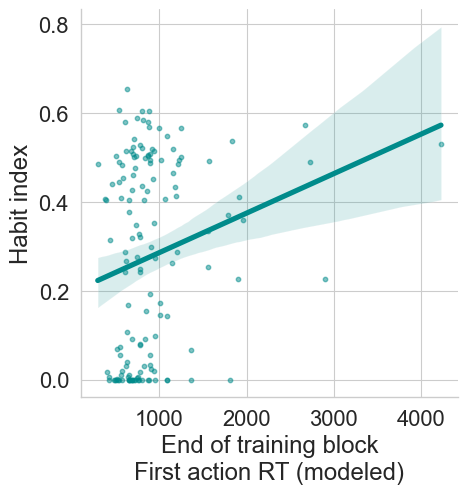

(144, 10)


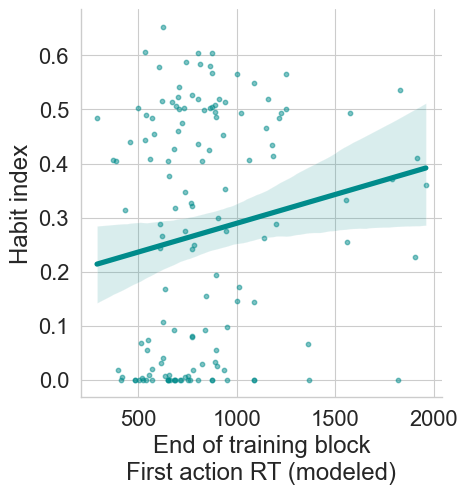

Pearson correlation for end_of_training_pred with habit_level: 0.205, p-value: 0.0069
Spearman correlation for end_of_training_pred with habit_level: 0.222, p-value: 0.0037


In [42]:
sns.set_context("paper", font_scale=1.8, rc={
    "lines.linewidth": 2.5,
    "lines.markersize": 8
})

only_after_devalued_data = main_data_df_w_fitting.copy()
only_after_devalued_data['habit_level'] = 1 - only_after_devalued_data['devaluation_ratio']

pallette = ['#008B8B']

print(only_after_devalued_data.shape)
sns.lmplot(data=only_after_devalued_data, x='end_of_training_pred', y='habit_level', hue='group', palette=pallette, order=1,scatter_kws={'s': 10, 'alpha': 0.5}, height=5, aspect=1, legend=False) 
plt.ylabel('Habit index')
plt.xlabel('End of training block\nFirst action RT (modeled)')
plt.show()

print(only_after_devalued_data.shape)
sns.lmplot(data=only_after_devalued_data[only_after_devalued_data.end_of_training_pred<2000], x='end_of_training_pred', y='habit_level', hue='group', palette=pallette, order=1,scatter_kws={'s': 10, 'alpha': 0.5}, height=5, aspect=1, legend=False) 
plt.ylabel('Habit index')
plt.xlabel('End of training block\nFirst action RT (modeled)')
plt.show()

# Pearson correlation (and Spearman to verify robustness using non-parametric correlation):
pearson_corr, pearson_p = pearsonr(only_after_devalued_data['end_of_training_pred'], only_after_devalued_data['habit_level'], alternative='greater')
print(f"Pearson correlation for end_of_training_pred with habit_level: {pearson_corr:.3f}, p-value: {pearson_p:.4f}")
spearman_corr, spearman_p = spearmanr(only_after_devalued_data['end_of_training_pred'], only_after_devalued_data['habit_level'], alternative='greater')
print(f"Spearman correlation for end_of_training_pred with habit_level: {spearman_corr:.3f}, p-value: {spearman_p:.4f}")